<a href="https://colab.research.google.com/github/madenni/NN-DIP/blob/main/NS7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 1**

# Этап 1. Выбор и обработка исходных данных. Разделение на обучающую и тестовую выборку

In [ ]:
!pip install patchify

!pip install tensorflow==2.9.0
!pip install -U -q segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 121.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow
!pip install -q keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

tf.compat.v1.enable_eager_execution()
import segmentation_models as sm
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root_directory = '/content/drive/MyDrive/Semantic segmentation dataset/'

patch_size = 256

In [6]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size  
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
       
                # Разделяем изображение на части
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = single_patch_img[0] # Убираем лишние ненужные каналы, которые добавляет patchify.                              
                        # image_dataset.append(single_patch_img)
          
                        cv2.imwrite(root_directory+"Image/" + image_name + 
                                   "_patch_" + str(i) + str(j) + ".jpg", single_patch_img)

/content/drive/MyDrive/Semantic segmentation dataset/
/content/drive/MyDrive/Semantic segmentation dataset/Tile 6
/content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_008.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_004.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_009.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/Semantic s

In [7]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks': 
        masks = os.listdir(path)  
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):  
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)             
       
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                               

                        cv2.imwrite(root_directory+"Masks/" + mask_name + 
                                   "_patch_" + str(i) + str(j) + ".png", single_patch_mask)
 


Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_006.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_007.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_008.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks/image_part_009.png
Now patchifying mask: /content/drive/

In [8]:
train_img_dir = r'/content/drive/MyDrive/Semantic segmentation dataset/Data/Image/'
train_mask_dir = r'/content/drive/MyDrive/Semantic segmentation dataset/Data/Masks/'

In [9]:
img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

print(img_list, msk_list)

['image_part_001.jpg_patch_00.jpg', 'image_part_001.jpg_patch_01.jpg', 'image_part_001.jpg_patch_02.jpg', 'image_part_001.jpg_patch_03.jpg', 'image_part_001.jpg_patch_04.jpg', 'image_part_001.jpg_patch_05.jpg', 'image_part_001.jpg_patch_06.jpg', 'image_part_001.jpg_patch_07.jpg', 'image_part_001.jpg_patch_10.jpg', 'image_part_001.jpg_patch_11.jpg', 'image_part_001.jpg_patch_12.jpg', 'image_part_001.jpg_patch_13.jpg', 'image_part_001.jpg_patch_14.jpg', 'image_part_001.jpg_patch_15.jpg', 'image_part_001.jpg_patch_16.jpg', 'image_part_001.jpg_patch_17.jpg', 'image_part_001.jpg_patch_20.jpg', 'image_part_001.jpg_patch_21.jpg', 'image_part_001.jpg_patch_22.jpg', 'image_part_001.jpg_patch_23.jpg', 'image_part_001.jpg_patch_24.jpg', 'image_part_001.jpg_patch_25.jpg', 'image_part_001.jpg_patch_26.jpg', 'image_part_001.jpg_patch_27.jpg', 'image_part_001.jpg_patch_30.jpg', 'image_part_001.jpg_patch_31.jpg', 'image_part_001.jpg_patch_32.jpg', 'image_part_001.jpg_patch_33.jpg', 'image_part_001.jpg

<Figure size 1200x800 with 0 Axes>

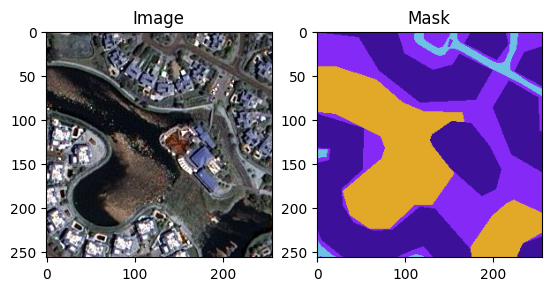

<Figure size 1200x800 with 0 Axes>

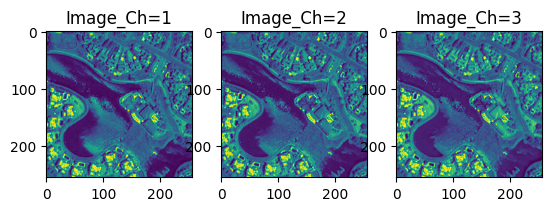

<Figure size 1200x800 with 0 Axes>

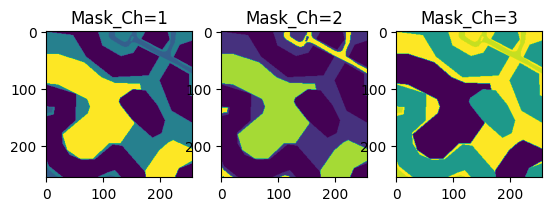

In [10]:
import random

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num])
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num])
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

# Combine all the operations and display
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()

In [11]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import splitfolders  # or import split_folders

input_folder = r'/content/drive/MyDrive/Semantic segmentation dataset/Data/'
output_folder = r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 1098 files [00:29, 36.98 files/s] 


In [13]:
import os
print(len(os.listdir('/content/drive/MyDrive/Semantic segmentation dataset/NewData/train_image/train/')))
print(len(os.listdir('/content/drive/MyDrive/Semantic segmentation dataset/NewData/train_mask/mask')))

print(len(os.listdir('/content/drive/MyDrive/Semantic segmentation dataset/NewData/val_image/train')))
print(len(os.listdir('/content/drive/MyDrive/Semantic segmentation dataset/NewData/val_mask/mask')))

411
411
138
138


# Этап 2. Предобработка обучающей и валидационной выборки. Разработка архитектуры модели

In [14]:
#Convert HEX to RGB array

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [15]:
def rgb_to_2D_label(label):
    """
    Замена значений каждого пикселя маски в формате RGB на целое число 
    
    """

    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

In [17]:
seed=24
batch_size= 16
n_classes=6

In [18]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [19]:
train_img_path = r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/train_image/'
train_mask_path = r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/train_mask/'

train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=6)

val_img_path = r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/val_image/'
val_mask_path = r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/val_mask/'
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=6)

Found 411 images belonging to 1 classes.
Found 411 images belonging to 1 classes.


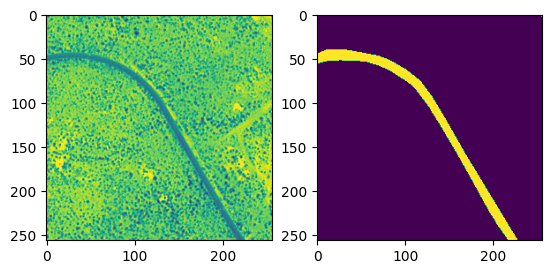

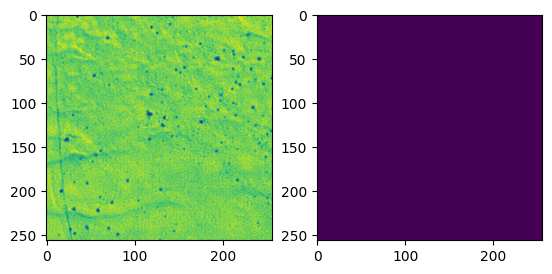

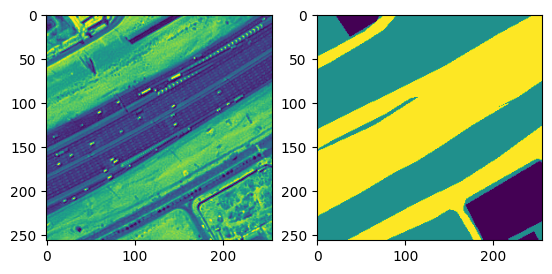

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.


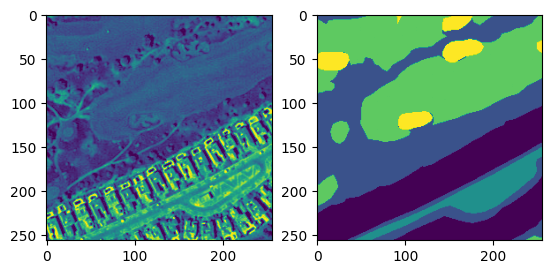

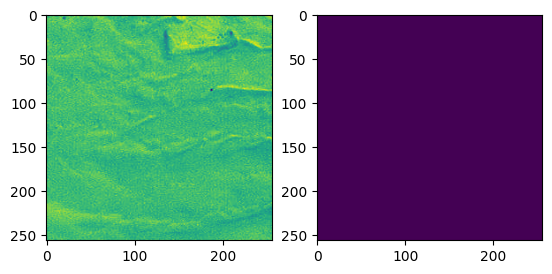

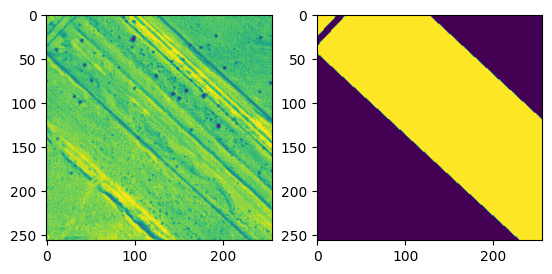

Unique labels in label dataset are:  [1 2]


In [20]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i][:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

In [21]:
num_train_imgs = len(os.listdir(r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/train_image/train/'))
num_val_images = len(os.listdir(r'/content/drive/MyDrive/Semantic segmentation dataset/NewData/val_mask/mask/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=6

print(num_train_imgs, steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(num_train_imgs, num_val_images, steps_per_epoch, val_steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

411 25 256 256 3
411 138 25 8 256 256 3


In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
#from tensorflow.keras.optimizers import Adam

def jacard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [23]:
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
metrics = ['accuracy', jacard_coef, sm.metrics.iou_score, tf.keras.metrics.MeanIoU(num_classes=6)]
# loss='categorical_crossentropy'
loss=sm.losses.categorical_focal_jaccard_loss
BACKBONE = 'resnet50'
n_classes = 6
opt = Adam(lr=0.001)
model_resnet_backbone0 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_resnet_backbone0.compile(optimizer=opt, loss=loss, metrics=metrics)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


94592056/94592056 [==============================] - 6s 0us/step


# Этап 3. Обучение модели

In [24]:
history1=model_resnet_backbone0.fit(
          train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/100
25/25 [==============================] - 338s 13s/step - loss: 0.8234 - accuracy: 0.6657 - jacard_coef: 0.3075 - iou_score: 0.2111 - mean_io_u: 0.4167 - val_loss: 1.5309 - val_accuracy: 0.0895 - val_jacard_coef: 0.0455 - val_iou_score: 0.0770 - val_mean_io_u: 0.3694
Epoch 2/100
25/25 [==============================] - 18s 716ms/step - loss: 0.6525 - accuracy: 0.7726 - jacard_coef: 0.5539 - iou_score: 0.3725 - mean_io_u: 0.4167 - val_loss: 1.5684 - val_accuracy: 0.0918 - val_jacard_coef: 0.0512 - val_iou_score: 0.0426 - val_mean_io_u: 0.3708
Epoch 3/100
25/25 [==============================] - 18s 721ms/step - loss: 0.6105 - accuracy: 0.8042 - jacard_coef: 0.6352 - iou_score: 0.4201 - mean_io_u: 0.4167 - val_loss: 1.5763 - val_accuracy: 0.0896 - val_jacard_coef: 0.0460 - val_iou_score: 0.0287 - val_mean_io_u: 0.3783
Epoch 4/100
25/25 [==============================] - 18s 728ms/step - loss: 0.5771 - accuracy: 0.8104 - jacard_coef: 0.6599 - iou_score: 0.4548 - mean_io_u: 0.41

In [25]:
print(model_resnet_backbone0.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

# Этап 4. Визуализация процесса обучения. Оценка точности

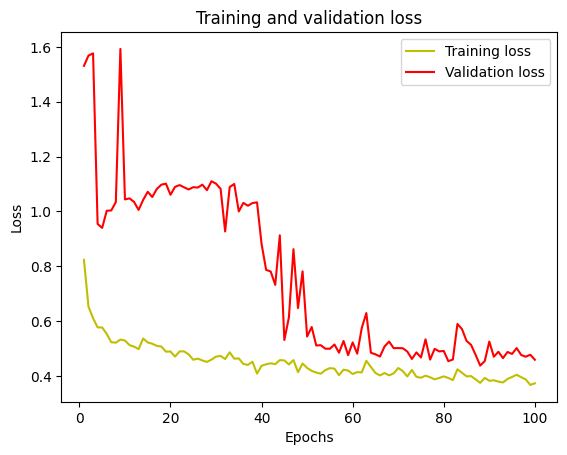

In [26]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

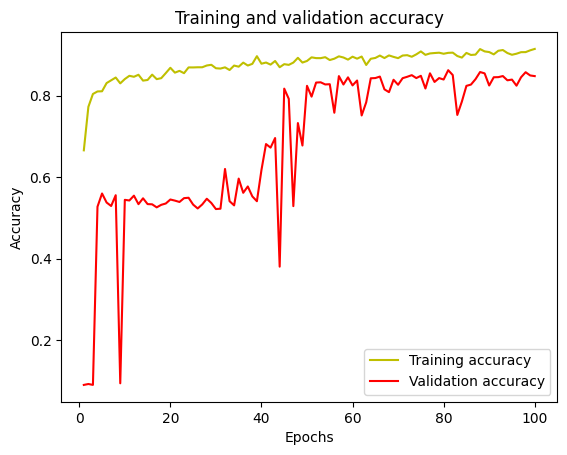

In [27]:
history = history1
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

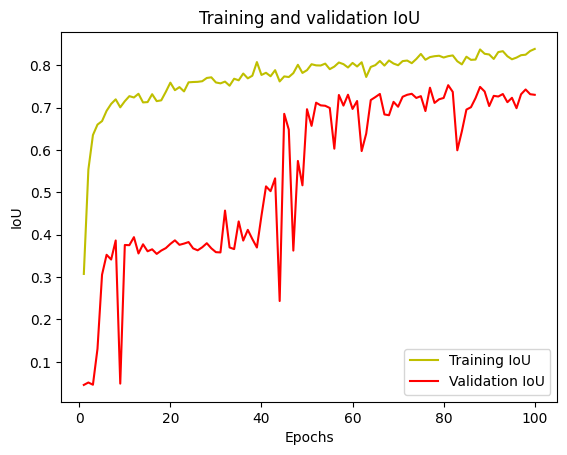

In [28]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [29]:
model_resnet_backbone0.save('/content/drive/MyDrive/ModelNN71.h5')

In [31]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/ModelNN71.h5', compile=False)

test_image_batch, test_mask_batch = train_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)

print("Mean IoU =", IOU_keras.result().numpy()) 

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.72753525


<Figure size 1200x800 with 0 Axes>

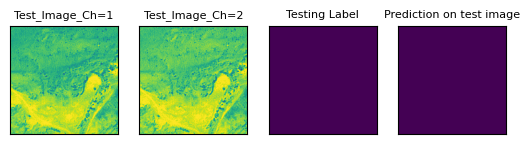

<Figure size 1200x800 with 0 Axes>

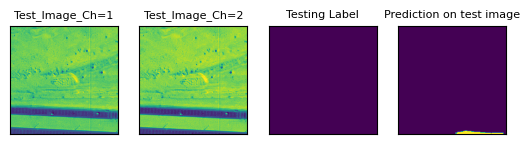

<Figure size 1200x800 with 0 Axes>

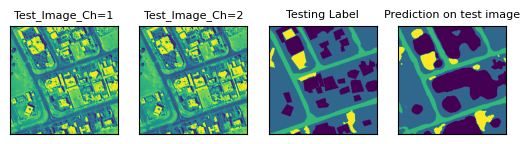

<Figure size 1200x800 with 0 Axes>

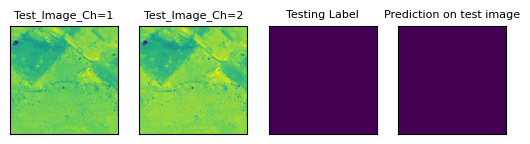

<Figure size 1200x800 with 0 Axes>

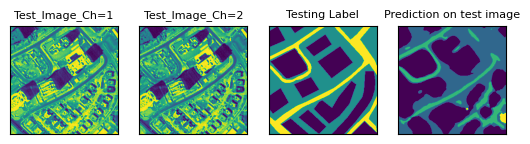

<Figure size 1200x800 with 0 Axes>

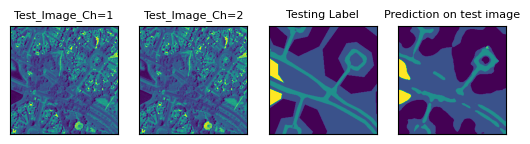

<Figure size 1200x800 with 0 Axes>

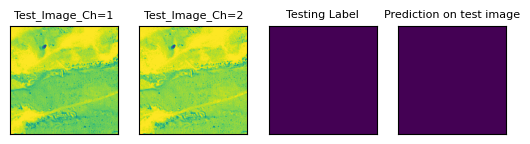

<Figure size 1200x800 with 0 Axes>

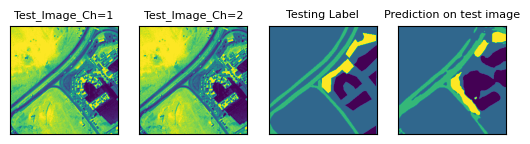

<Figure size 1200x800 with 0 Axes>

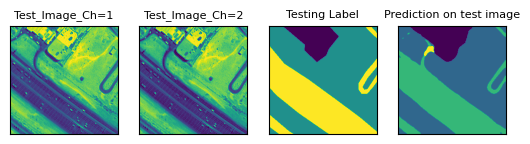

<Figure size 1200x800 with 0 Axes>

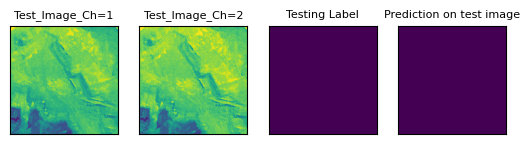

<Figure size 1200x800 with 0 Axes>

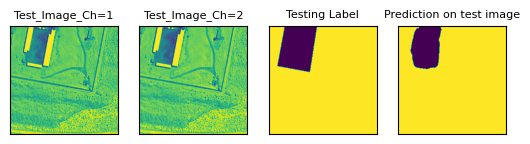

<Figure size 1200x800 with 0 Axes>

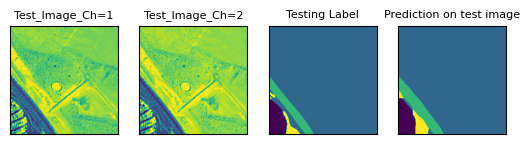

<Figure size 1200x800 with 0 Axes>

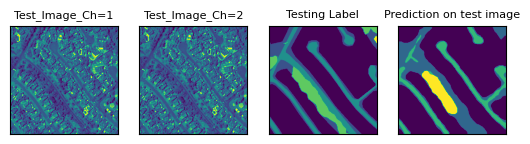

<Figure size 1200x800 with 0 Axes>

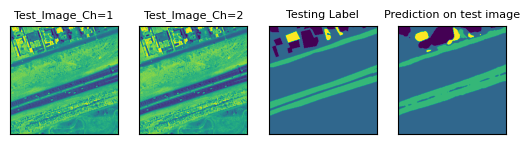

<Figure size 1200x800 with 0 Axes>

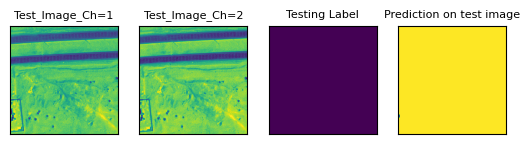

In [32]:
for img_num in range(test_image_batch.shape[0]-1):   

    fig=plt.figure(figsize=(12,8), facecolor='w', edgecolor='k')

    figure, axis = plt.subplots(1, 4)
    fig.tight_layout()

    axis[0].imshow(test_image_batch[img_num][:,:,0])
    axis[0].set_title('Test_Image_Ch=1', fontsize = 8)
    axis[0].axes.xaxis.set_visible(False)
    axis[0].axes.yaxis.set_visible(False)

    axis[1].imshow(test_image_batch[img_num][:,:,1])
    axis[1].set_title('Test_Image_Ch=2', fontsize = 8)
    axis[1].axes.xaxis.set_visible(False)
    axis[1].axes.yaxis.set_visible(False)

    axis[2].imshow(test_mask_batch_argmax[img_num])
    axis[2].set_title("Testing Label", fontsize = 8)
    axis[2].axes.xaxis.set_visible(False)
    axis[2].axes.yaxis.set_visible(False)

    axis[3].imshow(test_pred_batch_argmax[img_num])
    axis[3].set_title("Prediction on test image", fontsize = 8)
    axis[3].axes.xaxis.set_visible(False)
    axis[3].axes.yaxis.set_visible(False)

    plt.show()